# Autocodificadores

Fazer um jupyter notebook com autocodificador, a exemplo do exemplo mostrado em aula usando o Keras:

- https://t-adessowiki.fee.unicamp.br/user/aluno/notebooks/ia368z_2s2017/ia368z/deliver-keras/DenseAutoencoder.ipynb

Com as seguintes modificações:

- Utilizar o PyTorch
- Se possível, utilizar um autocodificador convolucional, porém não é imperativo
- Uma vez que o autocodificador seja treinado e o espaço bidimensional seja mostrado dos códigos dos dígitos da base de dados NMIST, gerar novas imagens:
  - mostrar algumas imagens em pontos quaisquer neste espaço bidimensional
  - dados dois pontos neste espaço, mostrar várias imagens, começando no ponto 1 e caminhando numa reta que une os dois pontos, gerar imagens associadas a pontos igualmente espaçados nessa reta, até chegar ao segundo ponto. É se esperar que os números gerados sejam interpolados entre eles.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import OrderedDict

from PIL import Image
from IPython import display

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [2]:
x_train, y_train = torch.load('/data/datasets/MNIST/processed/training.pt')
x_test,  y_test  = torch.load('/data/datasets/MNIST/processed/test.pt')

In [3]:
print(x_train.shape, x_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## Treinando com pouquíssimos dados

In [4]:
if True:
    n_train_samples = 1000
    n_test_samples = 500
    xx_train = x_train[:n_train_samples].type(torch.FloatTensor) /255.
    yy_train = y_train[:n_train_samples] 
    xx_test  = x_test[:n_test_samples].type(torch.FloatTensor) / 255.
    yy_test  = y_test[:n_test_samples]

In [5]:
xx_train.shape, xx_test.shape

(torch.Size([1000, 28, 28]), torch.Size([500, 28, 28]))

In [6]:
xx_train.type(),yy_train.type(), xx_test.type(), yy_test.type()

('torch.FloatTensor',
 'torch.LongTensor',
 'torch.FloatTensor',
 'torch.LongTensor')

## Cria a rede

In [18]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super(MyAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(28*28, 512)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(512, 128)),
            ('relu2', nn.ReLU()),
            ('dense3', nn.Linear(128, 2))
        ]))
        
        self.decoder = nn.Sequential(OrderedDict([
            ('dense3', nn.Linear(2, 128)),
            ('relu2', nn.ReLU()),
            ('dense2', nn.Linear(128, 512)),
            ('relu1', nn.ReLU()),
            ('dense1', nn.Linear(512, 28*28))
        ]))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 28, 28)
        
        return x
    
model = MyAutoEncoder()
model

MyAutoEncoder (
  (encoder): Sequential (
    (dense1): Linear (784 -> 512)
    (relu1): ReLU ()
    (dense2): Linear (512 -> 128)
    (relu2): ReLU ()
    (dense3): Linear (128 -> 2)
  )
  (decoder): Sequential (
    (dense3): Linear (2 -> 128)
    (relu2): ReLU ()
    (dense2): Linear (128 -> 512)
    (relu1): ReLU ()
    (dense1): Linear (512 -> 784)
  )
)

## Cria o trainer

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)
savebest = ptt.ModelCheckpoint('../../models/auto_encoder_pt',reset=True, verbose=1)
trainer = ptt.DeepNetTrainer( 
                         model, 
                         criterion, 
                         optimizer=optimizer,
                         lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                         callbacks = [savebest, ptt.PrintCallback()]
                        )

## Treinamento

In [21]:
trainer.fit(20,xx_train, xx_train, valid_data=(xx_test,xx_test) )

Start training for 20 epochs
 21:   0.2s   T: 0.04062   V: 0.04768 best
 22:   0.2s   T: 0.04062   V: 0.04769 
 23:   0.2s   T: 0.04062   V: 0.04768 best
 24:   0.2s   T: 0.04062   V: 0.04769 
 25:   0.2s   T: 0.04061   V: 0.04768 
 26:   0.2s   T: 0.04061   V: 0.04768 best
 27:   0.2s   T: 0.04061   V: 0.04768 
 28:   0.2s   T: 0.04060   V: 0.04768 best
 29:   0.2s   T: 0.04060   V: 0.04768 
 30:   0.2s   T: 0.04060   V: 0.04768 
 31:   0.2s   T: 0.04060   V: 0.04768 
 32:   0.2s   T: 0.04060   V: 0.04768 best
 33:   0.2s   T: 0.04060   V: 0.04768 
 34:   0.2s   T: 0.04060   V: 0.04768 
 35:   0.2s   T: 0.04060   V: 0.04768 
 36:   0.2s   T: 0.04060   V: 0.04768 
 37:   0.2s   T: 0.04060   V: 0.04768 
 38:   0.2s   T: 0.04060   V: 0.04768 best
 39:   0.2s   T: 0.04060   V: 0.04768 best
 40:   0.2s   T: 0.04060   V: 0.04768 
Best model was saved at epoch 39 with loss 0.04768: ../../models/auto_encoder_pt
Stop training at epoch: 40/40


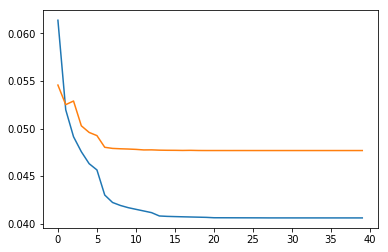

In [22]:
tra_loss = trainer.metrics['train']['losses']
val_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(tra_loss))
plt.plot(epochs, tra_loss, epochs, val_loss)

In [23]:
trainer.load_state('../../models/auto_encoder_pt')

In [26]:
yy_pred = trainer.predict(xx_test)

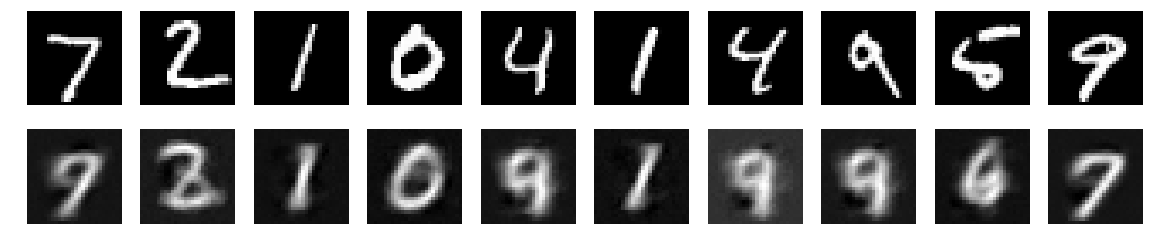

In [27]:
n = 10
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xx_test[i].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(yy_pred[i].cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## Imagens no plano 2D

In [32]:
#encoded = trainer.model.encoder.forward(Variable(xx_train))

In [34]:
batch_size = 20
test_dl = DataLoader(ae_data_test, batch_size=batch_size, shuffle=False, num_workers=4)

encoded_data = np.zeros((len(ae_data_test), 2))
for i, (data, _) in enumerate(test_dl):
    inputs = data.view(-1, 28*28)
    encoded = model.encoder(Variable(inputs.cuda()))
    encoded_data[i*batch_size:(i+1)*batch_size] = encoded.data.cpu().numpy()

plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=ae_data_test.labels_data.numpy(), cmap=plt.cm.tab10)
plt.colorbar();
plt.show()

NameError: name 'DataLoader' is not defined

## transformação na imagem ao percorrer uma linha no espaço 2D

In [ ]:
n = 40
x = np.linspace(-5.0, 10.0, n)
y = np.linspace(10.0, -10.0, n)

data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

out = model.decoder(Variable(data.cuda()))
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()